In [1]:
import mysql.connector
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pandas as pd

def table_df(database_name, table_name):
    username = "root"
    password = "mysql%40123"
    host = "localhost"
    port = 3306

    conn_url = f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database_name}"
    engine = create_engine(conn_url)
    query = f'SELECT * FROM {table_name}'

    with engine.connect() as conn:
        df = pd.read_sql(sql=query, con=conn.connection)
    return df

def df_table(database_name, dataframe, table_name):
    
    conn_url = URL.create(
        "mysql+mysqlconnector",
        username = "root",
        password = "mysql@123",
        host = "localhost",
        port = 3306,
        database = database_name) # Alternative way to create connection url
    
    engine = create_engine(conn_url)
    con = engine.connect()
    df.to_sql(table_name, con=con, if_exists='replace', index=False)  

In [2]:
df = table_df('client_rw', 'fc_transaction_base')

C:\Users\Ngawang Gurung\AppData\Local\Temp\ipykernel_16372\616552780.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql=query, con=conn.connection)


In [3]:
df.head()

,tran_date,account_number,branch,product,lcy_amount,transaction_code,description1,dc_indicator,is_salary
0,2020-06-09,02XYZXYZ10017529992,15,SBA,14500.0,CI,ATM WDL /00463701/NABIL\NABIL,withdraw,0
1,2020-06-14,02XYZXYZ10017529992,15,SBA,20000.0,CI,ATM WDL /00463701/NABIL\NABIL,withdraw,0
2,2020-06-01,02XYZXYZ10017517823,15,SBA,4000.0,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0
3,2020-06-05,02XYZXYZ10017517823,15,SBA,500.0,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0
4,2020-06-12,02XYZXYZ10017517823,15,SBA,5000.0,CI,ATM WDL /NICAV701/\Pharping\KT,withdraw,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44243 entries, 0 to 44242
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tran_date         44243 non-null  datetime64[ns]
 1   account_number    44243 non-null  object        
 2   branch            44243 non-null  int64         
 3   product           44243 non-null  object        
 4   lcy_amount        44243 non-null  float64       
 5   transaction_code  44243 non-null  object        
 6   description1      44173 non-null  object        
 7   dc_indicator      44243 non-null  object        
 8   is_salary         44243 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 3.0+ MB


In [5]:
filterd_df = df[['branch', 'account_number']].drop_duplicates()

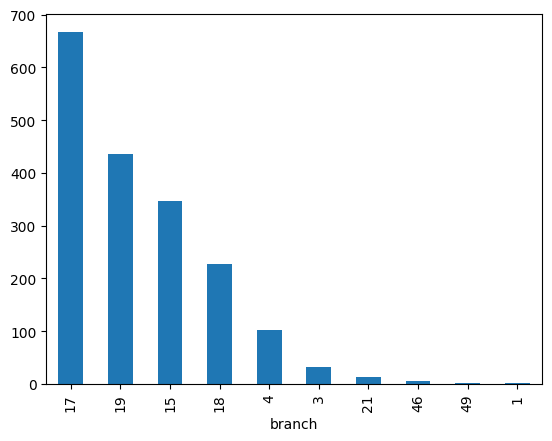

In [7]:
filterd_df.branch.value_counts()[:10].plot(kind = 'bar');

In [10]:
df['tran_date'].min(),df['tran_date'].max()

(Timestamp('2020-06-01 00:00:00'), Timestamp('2020-08-16 00:00:00'))

In [12]:
import datetime as dt

PRESENT = dt.datetime(2020, 8, 17)

rfm= df.groupby('account_number').agg({'tran_date': lambda date: (PRESENT - date.max()).days,
                                        'product': lambda num: len(num),
                                        'lcy_amount': lambda price: price.sum()})

In [13]:
rfm

,tran_date,product,lcy_amount
account_number,,,
02XYZXYZ10015339701,8,27,9196718.71
02XYZXYZ10015571501,10,27,4895507.77
02XYZXYZ10015571601,33,3,29896.10
02XYZXYZ10015592101,4,43,11711419.97
02XYZXYZ10015593701,3,21,4187990.01
...,...,...,...
02XYZXYZ110017507494,3,19,84277.79
02XYZXYZ110017507511,20,35,108973.12
02XYZXYZ110017507523,3,19,406725.50


In [14]:
rfm.columns=['recency', 'frequency', 'monetary'] 

In [15]:
rfm['recency'] = rfm['recency'].astype(int)

In [16]:
rfm.head()

,recency,frequency,monetary
account_number,,,
02XYZXYZ10015339701,8,27,9196718.71
02XYZXYZ10015571501,10,27,4895507.77
02XYZXYZ10015571601,33,3,29896.10
02XYZXYZ10015592101,4,43,11711419.97
02XYZXYZ10015593701,3,21,4187990.01


In [17]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1','2','3','4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4','3','2','1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4','3','2','1'])

In [18]:
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
account_number,,,,,,
02XYZXYZ10015339701,8,27,9196718.71,3,2,1
02XYZXYZ10015571501,10,27,4895507.77,3,2,1
02XYZXYZ10015571601,33,3,29896.10,4,4,4
02XYZXYZ10015592101,4,43,11711419.97,1,1,1
02XYZXYZ10015593701,3,21,4187990.01,1,2,1


In [19]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()


,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
account_number,,,,,,,
02XYZXYZ10015339701,8,27,9196718.71,3,2,1,321
02XYZXYZ10015571501,10,27,4895507.77,3,2,1,321
02XYZXYZ10015571601,33,3,29896.10,4,4,4,444
02XYZXYZ10015592101,4,43,11711419.97,1,1,1,111
02XYZXYZ10015593701,3,21,4187990.01,1,2,1,121


In [20]:
# Filter out Top/Best cusotmers
rfm[rfm['RFM_Score']=='111'].sort_values('monetary', ascending=False).head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
account_number,,,,,,,
02XYZXYZ10017521017,1,421,66511335.64,1,1,1,111
02XYZXYZ10017521010,3,50,60485642.55,1,1,1,111
02XYZXYZ10017297501,4,53,27622644.74,1,1,1,111
02XYZXYZ10017537563,4,38,20961799.47,1,1,1,111
02XYZXYZ10017516362,3,52,18768342.10,1,1,1,111
